# Portfolio Construction using Black-Litterman Model

## Asset classes selection

| Index | Name                                  | Ticker | Variable     | Factor            |
|-------|---------------------------------------|--------|--------------|-------------------|
| 0     | SPDR S&P 500 ETF Trust                | SPY    | sp500        | Benchmark         |
| 1     | Berkshire Hathaway Inc.               | BRK.B  | eq_brkb      | Equity Value      |
| 2     | UnitedHealth Group Incorporated       | UNH    | eq_unh       | Equity Value      |
| 3     | JPMorgan Chase & Co.                  | JPM    | eq_jpm       | Equity Value      |
| 4     | Exxon Mobil Corporation               | XOM    | eq_xom       | Equity Value      |
| 5     | Broadcom Inc.                         | AVGO   | eq_avgo      | Equity Value      |
| 6     | Meta Platforms, Inc.                  | META   | eq_meta      | Equity Growth     |
| 7     | Tesla, Inc.                           | TSLA   | eq_tsla      | Equity Growth     |
| 8     | Eli Lilly and Company                 | LLY    | eq_lly       | Equity Growth     |
| 9     | Visa Inc.                             | V      | eq_visa      | Equity Growth     |
| 10    | Mastercard Incorporated               | MA     | eq_mcard     | Equity Growth     |
| 11    | Microsoft Corporation                 | MSFT   | eq_msft      | Equity Large Cap  |
| 12    | Apple Inc.                            | AAPL   | eq_aapl      | Equity Large Cap  |
| 13    | Amazon.com, Inc.                      | AMZN   | eq_amzn      | Equity Large Cap  |
| 14    | NVIDIA Corporation                    | NVDA   | eq_nvda      | Equity Large Cap  |
| 15    | Alphabet Inc.                         | GOOGL  | eq_googl     | Equity Large Cap  |
| 16    | Targa Resources Corp.                 | TRGP   | eq_trgp      | Equity Low Cap    |
| 17    | PTC Inc.                              | PTC    | eq_ptc       | Equity Low Cap    |
| 18    | Deckers Outdoor Corporation           | DECK   | eq_deck      | Equity Low Cap    |
| 19    | Atmos Energy Corporation              | ATO    | eq_ato       | Equity Low Cap    |
| 20    | Builders FirstSource, Inc.            | BLDR   | eq_bldr      | Equity Low Cap    |
| 21    | iShares Short Treasury Bond ETF       | SHV    | bond_short   | Shorterm Bond     |
| 22    | iShares 20+ Year Treasury Bond ETF    | TLT    | bond_long    | Longterm Bond     |
| 23    | United States Oil Fund LP             | USO    | com_oil      | Commodity         |
| 24    | iShares Gold Trust                    | IAU    | com_gold     | Commodity         |
| 25    | iShares MSCI USA Momentum Factor ETF  | MTUM   | momentum     | Momentum Factor   |
| 26    | Risk-free rate - Kenneth French Data  | N/A    | rf_rate      | Risk free rate    |


In [163]:
import pandas as pd
import math
import pandas_datareader as pdr
import statsmodels.api as sm
import yfinance as yf
import numpy as np
from numpy.linalg import multi_dot
import scipy.optimize as sco

import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt


# Format for vector output
float_formatter = "{:.6f}".format
np.set_printoptions(formatter={'float_kind':float_formatter})

Download the data and save it to the `..\data` folder

In [164]:
import yfinance as yf
import pandas as pd
import time

# Define tickers and date range
tickers = [
    'SPY', 'BRK-B', 'UNH', 'JPM', 'XOM', 'AVGO', 'META', 'TSLA', 'LLY', 'V',
    'MA', 'MSFT', 'AAPL', 'AMZN', 'NVDA', 'GOOGL', 'TRGP', 'PTC', 'DECK',
    'ATO', 'BLDR', 'SHV', 'TLT', 'USO', 'IAU', 'MTUM'
]
start_date = '2020-04-01'
end_date = '2025-04-30'

# Optional: fix BRK-B formatting for Yahoo Finance
tickers = [t.replace('-', '-') for t in tickers]

# Store individual data
price_data = pd.DataFrame()
failed_tickers = []

def safe_download(tickers, start, end, interval='1d', max_retries=3, pause=1.5):
    adj_close_df = pd.DataFrame()
    volume_df = pd.DataFrame()

    for ticker in tickers:
        success = False
        retries = 0
        while not success and retries < max_retries:
            try:
                print(f"Downloading {ticker} (Attempt {retries+1})...")
                ticker_data = yf.Ticker(ticker).history(start=start, end=end, interval=interval)
                if ticker_data.empty:
                    raise ValueError(f"No data returned for {ticker}")

                adj_close_df[ticker] = ticker_data['Close']
                volume_df[ticker] = ticker_data['Volume']
                success = True
                time.sleep(pause)  # to avoid rate-limiting
            except Exception as e:
                print(f"Failed to download {ticker}: {e}")
                retries += 1
                time.sleep(pause)

        if not success:
            print(f"WARNING: Skipping {ticker} after {max_retries} failed attempts.")

    return adj_close_df, volume_df

# Save the successful data to CSV
adj_close, volumes = safe_download(tickers, start=start_date, end=end_date)
adj_close.to_csv('../data/portfolio_prices.csv')
volumes.to_csv('../data/portfolio_volumes.csv')
print("\n✅ Download complete!")
print("✅ Data saved to ../data/")
if failed_tickers:
    print("\n⚠️ Failed tickers:")
    print(failed_tickers)



✅ Download complete!
✅ Data saved to ../data/


In [165]:
# variables = [
#     "sp500","eq_brkb", "eq_unh", "eq_jpm", "eq_xom", "eq_avgo", "eq_meta", "eq_tsla", 
#     "eq_lly", "eq_visa", "eq_mcard", "eq_msft", "eq_aapl", "eq_amzn", "eq_nvda", 
#     "eq_googl", "eq_trgp", "eq_ptc", "eq_deck", "eq_ato", "eq_bldr", "bond_short", 
#     "bond_long", "com_oil", "com_gold", "momentum"
# ]
daily_price = pd.read_csv('../data/portfolio_prices.csv').set_index('Date')
daily_volumes = pd.read_csv('../data/portfolio_volumes.csv').set_index('Date')
# daily_price.columns = variables
# daily_volumes.columns = variables
#Renames the columns from tickers(like AAPL, UNH, etc.) to variable names like eq_aapl, eq_unh (from your earlier variables list).

# Extracts the S&P 500 ETF (SPY) column as a benchmark.
# Removes it from the main daily_price dataframe so it doesn't interfere with portfolio assets.
sp500 = daily_price.SPY
daily_price.drop('SPY', axis=1, inplace=True)

Compute the daily returns

In [42]:
daily_rets = daily_price.pct_change()[1:]
daily_rets.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1275 entries, 2020-04-02 00:00:00-04:00 to 2025-04-29 00:00:00-04:00
Data columns (total 25 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   BRK-B   1275 non-null   float64
 1   UNH     1275 non-null   float64
 2   JPM     1275 non-null   float64
 3   XOM     1275 non-null   float64
 4   AVGO    1275 non-null   float64
 5   META    1275 non-null   float64
 6   TSLA    1275 non-null   float64
 7   LLY     1275 non-null   float64
 8   V       1275 non-null   float64
 9   MA      1275 non-null   float64
 10  MSFT    1275 non-null   float64
 11  AAPL    1275 non-null   float64
 12  AMZN    1275 non-null   float64
 13  NVDA    1275 non-null   float64
 14  GOOGL   1275 non-null   float64
 15  TRGP    1275 non-null   float64
 16  PTC     1275 non-null   float64
 17  DECK    1275 non-null   float64
 18  ATO     1275 non-null   float64
 19  BLDR    1275 non-null   float64
 20  SHV     1275 non-null   float64
 2

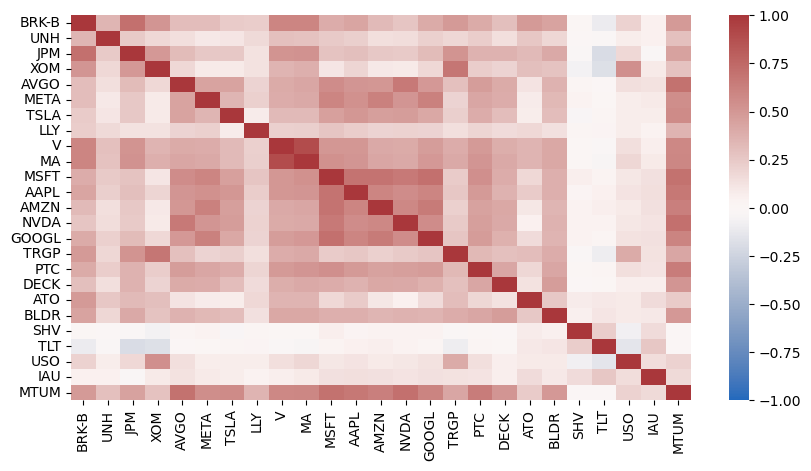

In [43]:
fig, ax = plt.subplots(figsize=(10 , 5))
sns.heatmap(daily_rets.corr(), annot=False, vmax=1, vmin=-1, center=0, cmap='vlag') # if want to show correlation numbers inside each cell, set annot=True.
plt.show()

Create `high_corr` filter to identify highly correlated assets and drop them from the portfolio

In [44]:
def high_corr(data, threshold=0.5):
    col_corr = set()
    corr_matrix = data
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold:
                colname = corr_matrix.columns[i]
                col_corr.add(colname)
    return col_corr
mask_high_corr = high_corr(daily_rets.corr())
mask_high_corr

{'AAPL',
 'AMZN',
 'GOOGL',
 'JPM',
 'MA',
 'MSFT',
 'MTUM',
 'NVDA',
 'PTC',
 'TRGP',
 'USO',
 'V',
 'XOM'}

In [45]:
# Alternatively: Drop Highly Correlated Tickers Based on Lower Average Volume
avg_volumes = daily_volumes.mean()

def drop_low_volume_assets(corr_matrix, avg_volumes, threshold):
    tickers_to_drop = set()
    cols = corr_matrix.columns
    for i in range(len(cols)):
        for j in range(i+1, len(cols)):
            t1, t2 = cols[i], cols[j]
            if abs(corr_matrix.loc[t1, t2]) > threshold:
                if avg_volumes[t1] < avg_volumes[t2]:
                    tickers_to_drop.add(t1)
                else:
                    tickers_to_drop.add(t2)
    return tickers_to_drop

drop_volume_based = drop_low_volume_assets(daily_rets.corr(), avg_volumes, 0.5)
drop_volume_based

{'AAPL',
 'AMZN',
 'AVGO',
 'BRK-B',
 'GOOGL',
 'MA',
 'META',
 'MSFT',
 'MTUM',
 'PTC',
 'TRGP',
 'USO',
 'V'}

In [46]:
daily_rets_filtered = daily_rets.drop(drop_volume_based , axis=1)
daily_rets_filtered['sp500'] = sp500.pct_change()
daily_rets_filtered.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
UNH,1275.0,0.000637,0.017221,-0.223797,-0.007200,0.000896,0.008995,0.103345
JPM,1275.0,0.001110,0.017833,-0.083443,-0.008009,0.001005,0.010093,0.135392
XOM,1275.0,0.001216,0.019964,-0.088253,-0.010490,0.000728,0.012062,0.126601
TSLA,1275.0,0.002560,0.040838,-0.210628,-0.020375,0.001659,0.022988,0.226900
LLY,1275.0,0.001711,0.019947,-0.090927,-0.008628,0.001057,0.010459,0.156798
NVDA,1275.0,0.002827,0.033567,-0.169682,-0.016232,0.003190,0.022436,0.243696
DECK,1275.0,0.001685,0.026867,-0.205056,-0.013059,0.001516,0.016178,0.189422
ATO,1275.0,0.000602,0.013593,-0.073803,-0.006571,0.000879,0.008107,0.100574
BLDR,1275.0,0.002312,0.030709,-0.190462,-0.014201,0.002456,0.018547,0.174152
SHV,1275.0,0.000095,0.000184,-0.000817,0.000000,0.000091,0.000181,0.001180


Calculate cummulative returns

In [47]:
cum_rets_filtered = (1 + daily_rets_filtered).cumprod() - 1
cum_rets_filtered.head()

,UNH,JPM,XOM,TSLA,LLY,NVDA,DECK,ATO,BLDR,SHV,TLT,IAU,sp500
Date,,,,,,,,,,,,,
2020-04-02 00:00:00-04:00,0.013147,0.037340,0.076473,-0.056255,0.042222,0.051014,0.023758,0.028846,0.005227,0.000000,0.006345,0.016480,0.023075
2020-04-03 00:00:00-04:00,-0.032993,0.006679,0.044764,-0.003219,0.023750,0.003456,-0.013252,-0.005072,-0.049652,-0.000361,0.008740,0.023731,0.008288
2020-04-06 00:00:00-04:00,0.046435,0.071475,0.078338,0.072016,0.038045,0.104209,0.118061,0.094991,0.115854,-0.000270,0.006106,0.050758,0.076011
2020-04-07 00:00:00-04:00,0.045171,0.085608,0.098854,0.132673,0.040024,0.065660,0.140768,0.039941,0.183798,0.000180,-0.004430,0.046803,0.077107
2020-04-08 00:00:00-04:00,0.128561,0.129444,0.168399,0.139713,0.071837,0.098243,0.172364,0.084637,0.182927,-0.000361,-0.011674,0.034278,0.113264


Plot the daily returns data

In [48]:
# reset the index, using date as column
daily_rets_filtered = daily_rets_filtered.reset_index()
# use "melt". reshapes the DataFrame from wide format to long format, which is necessary for plotting libraries (like Plotly or Seaborn).This makes it easier to plot multiple lines, one per ticker, over time
df1 = daily_rets_filtered.melt(id_vars=['Date'], var_name='ticker', value_name='daily_return')
# add one more column, showing the daily_return as percent
df1['daily_return_pct'] = df1['daily_return'] * 100
df1

,Date,ticker,daily_return,daily_return_pct
0,2020-04-02 00:00:00-04:00,UNH,0.013147,1.314677
1,2020-04-03 00:00:00-04:00,UNH,-0.045541,-4.554142
2,2020-04-06 00:00:00-04:00,UNH,0.082138,8.213846
3,2020-04-07 00:00:00-04:00,UNH,-0.001208,-0.120803
4,2020-04-08 00:00:00-04:00,UNH,0.079786,7.978586
...,...,...,...,...
16570,2025-04-23 00:00:00-04:00,sp500,0.015495,1.549546
16571,2025-04-24 00:00:00-04:00,sp500,0.021049,2.104893
16572,2025-04-25 00:00:00-04:00,sp500,0.007225,0.722532
16573,2025-04-28 00:00:00-04:00,sp500,0.000381,0.038130


In [49]:
fig = px.line(df1, x='Date',
              y='daily_return_pct', color='ticker',
              title='Performance - Daily Simple Returns',
              labels={'daily_return_pct':'daily returns (%)'})
fig.show()

/Users/l/opt/anaconda3/lib/python3.9/site-packages/plotly/io/_renderers.py:55: UserWarning:

Plotly version >= 6 requires Jupyter Notebook >= 7 but you have 6.4.12 installed.
 To upgrade Jupyter Notebook, please run `pip install notebook --upgrade`.



Plot cummulative daily returns 

In [50]:
# reset the index, using date as column
cum_rets_filtered = cum_rets_filtered.reset_index()
df2 = cum_rets_filtered.melt(id_vars=['Date'], var_name='ticker', value_name='cum_return')
df2['cum_return_pct'] = df2['cum_return'] * 100
df2

,Date,ticker,cum_return,cum_return_pct
0,2020-04-02 00:00:00-04:00,UNH,0.013147,1.314677
1,2020-04-03 00:00:00-04:00,UNH,-0.032993,-3.299338
2,2020-04-06 00:00:00-04:00,UNH,0.046435,4.643506
3,2020-04-07 00:00:00-04:00,UNH,0.045171,4.517093
4,2020-04-08 00:00:00-04:00,UNH,0.128561,12.856079
...,...,...,...,...
16570,2025-04-23 00:00:00-04:00,sp500,1.339456,133.945622
16571,2025-04-24 00:00:00-04:00,sp500,1.388699,138.869928
16572,2025-04-25 00:00:00-04:00,sp500,1.405958,140.595841
16573,2025-04-28 00:00:00-04:00,sp500,1.406876,140.687581


In [51]:
fig = px.line(df2, x='Date',
              y='cum_return_pct', color='ticker',
              title='Performance - Daily Cumulative Returns',   
              labels={'cum_return_pct':'Daily cumulative returns (%)', })
fig.show()

/Users/l/opt/anaconda3/lib/python3.9/site-packages/plotly/io/_renderers.py:55: UserWarning:

Plotly version >= 6 requires Jupyter Notebook >= 7 but you have 6.4.12 installed.
 To upgrade Jupyter Notebook, please run `pip install notebook --upgrade`.



---

## Ledoit-Wolf Covariance Shrinkage

Implement the shrinkage estimator to estimate the covariance matrix

❓ Why not use the standard sample covariance?
The sample covariance matrix can be very noisy or unstable, especially when:
You have many assets (large N) But relatively few time points (small T) Which is common in finance (e.g., 100 stocks, 252 daily returns)
This noise can lead to poor performance in downstream tasks like mean-variance optimization, where the inverse of the covariance matrix is used.

What does LedoitWolf do? It shrinks the sample covariance matrix toward a more stable, structured estimator — usually a diagonal matrix or scaled identity matrix.

💡 Why is shrinkage useful?
"Shrinkage helps reduce noise in the estimation, which is critical for optimization problems like portfolio construction."

Because: Portfolio optimization involves inverting the covariance matrix to compute optimal weights. Inverting a noisy matrix leads to highly unstable and unreliable weights. Shrinkage smooths the covariance estimate, making it better-conditioned and more robust.
This makes the output:More stable; Less sensitive to estimation error; More reliable in practice, especially out-of-sample

In [73]:
daily_rets.columns

Index(['BRK-B', 'UNH', 'JPM', 'XOM', 'AVGO', 'META', 'TSLA', 'LLY', 'V', 'MA',
       'MSFT', 'AAPL', 'AMZN', 'NVDA', 'GOOGL', 'TRGP', 'PTC', 'DECK', 'ATO',
       'BLDR', 'SHV', 'TLT', 'USO', 'IAU', 'MTUM'],
      dtype='object')

In [168]:
from sklearn.covariance import LedoitWolf
#drop highly correlated tickers (identified earlier via mask_high_corr). 
filtered_daily_ret = daily_rets.drop(drop_volume_based , axis=1) 
# creates a Ledoit-Wolf estimator, fits it to the filtered daily returns, and computes the shrunk covariance matrix. Shrinkage helps reduce noise in the estimation, which is critical for optimization problems like portfolio construction.
cov_shrink = LedoitWolf().fit(filtered_daily_ret)
cov_matrix = cov_shrink.covariance_
pd.DataFrame(cov_matrix)

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.00030,0.00007,0.00006,0.00008,0.00006,0.00008,0.00007,0.00006,0.00010,-0.00000,-0.00000,0.00001
1,0.00007,0.00032,0.00017,0.00018,0.00005,0.00015,0.00017,0.00008,0.00022,-0.00000,-0.00004,-0.00000
2,0.00006,0.00017,0.00040,0.00007,0.00005,0.00006,0.00011,0.00008,0.00017,-0.00000,-0.00004,0.00002
3,0.00008,0.00018,0.00007,0.00165,0.00007,0.00064,0.00034,0.00004,0.00038,-0.00000,0.00001,0.00003
4,0.00006,0.00005,0.00005,0.00007,0.00040,0.00014,0.00009,0.00005,0.00008,0.00000,0.00001,0.00001
5,0.00008,0.00015,0.00006,0.00064,0.00014,0.00112,0.00036,0.00002,0.00037,0.00000,0.00002,0.00004
6,0.00007,0.00017,0.00011,0.00034,0.00009,0.00036,0.00072,0.00005,0.00038,-0.00000,0.00000,0.00002
7,0.00006,0.00008,0.00008,0.00004,0.00005,0.00002,0.00005,0.00019,0.00010,0.00000,0.00001,0.00002
8,0.00010,0.00022,0.00017,0.00038,0.00008,0.00037,0.00038,0.00010,0.00094,0.00000,0.00003,0.00003
9,-0.00000,-0.00000,-0.00000,-0.00000,0.00000,0.00000,-0.00000,0.00000,0.00000,0.00001,0.00000,0.00000


---

## Historical Weights

Calculate market cap weight

In [170]:
def get_market_caps(tickers, manual_caps=None):
    """
    Downloads market cap data for each ticker using yfinance.
    Allows manually assigning missing market caps.
    Returns a dictionary of {ticker: market_cap}.
    """
    caps = {}
    missing = []
    manual_caps = manual_caps or {}

    for ticker in tickers:
        try:
            stock = yf.Ticker(ticker)
            info = stock.info
            market_cap = info.get("marketCap", None)
            if market_cap is not None:
                caps[ticker] = market_cap
            else:
                missing.append(ticker)
        except Exception as e:
            print(f"Error retrieving {ticker}: {e}")
            missing.append(ticker)

    # Add manual market caps if provided
    for ticker in missing:
        if ticker in manual_caps:
            print(f"Using manual market cap for {ticker}: {manual_caps[ticker]}")
            caps[ticker] = manual_caps[ticker]
        else:
            print(f"Market cap missing and not manually provided for {ticker}")

    return caps

def calculate_market_weights(market_caps):
    """
    Normalizes market cap dictionary to weights summing to 1.
    Returns a column vector (NumPy array).
    """
    total = sum(market_caps.values())
    weights = np.array([cap / total for cap in market_caps.values()]).reshape(-1, 1)
    return weights

# Extract tickers from the filtered returns DataFrame
tickers_filtered = filtered_daily_ret.columns

# Optional: Provide manual market cap estimates for known missing tickers
manual_market_caps = {
    "SHV": 20_000_000_000  # Example: SHV has ~$20B AUM
}

# Download + patch market cap data
market_caps = get_market_caps(tickers_filtered, manual_caps=manual_market_caps)

# Check final ticker coverage
missing_caps = [t for t in tickers_filtered if t not in market_caps]
if missing_caps:
    print("⚠️ Still missing market caps for:", missing_caps)

# Convert to weights
market_weights = calculate_market_weights(market_caps)
market_weights

Using manual market cap for SHV: 20000000000


array([[0.039846],
       [0.108234],
       [0.065196],
       [0.170075],
       [0.095560],
       [0.500066],
       [0.002361],
       [0.003611],
       [0.001773],
       [0.001392],
       [0.008938],
       [0.002946]])

Download Fama French data for risk free rate and the market factor terms

In [171]:
famafrench_model = pdr.famafrench.FamaFrenchReader('F-F_Research_Data_Factors_daily',start=start_date, end=end_date).read()[0]
# This uses pandas_datareader to fetch Fama-French daily factor data.
# 'F-F_Research_Data_Factors_daily' tells the reader to retrieve the daily version of the Fama-French 3-factor model from the Kenneth French Data Library.
# .read() returns a dictionary of DataFrames; [0] selects the first one, which contains the actual factor returns.
# The returned DataFrame includes:
# Mkt-RF — excess return of the market
# SMB — size factor (Small Minus Big)
# HML — value factor (High Minus Low)
# RF — risk-free rate
famafrench_model = famafrench_model[1:] #This removes the first row, which may contain a summary or an invalid entry
famafrench_model = famafrench_model/100
famafrench_model.head()

,Mkt-RF,SMB,HML,RF
Date,,,,
2020-04-02,0.02100,-0.00970,-0.00280,0.00000
2020-04-03,-0.01640,-0.01090,-0.01150,0.00000
2020-04-06,0.07100,0.00770,0.00280,0.00000
2020-04-07,-0.00110,-0.00590,0.02100,0.00000
2020-04-08,0.03420,0.00310,0.01270,0.00000


Calculate market risk aversion

$$
\lambda = \frac{\mathbb{E}(r) - r_f}{\sigma^2}
$$

In [172]:
risk_free_rate = famafrench_model.RF
market_rets = sp500.pct_change().dropna()
market_risk_aversion = (market_rets.mean() - risk_free_rate.mean())/(market_rets.std()**2)
market_risk_aversion

4.8987899533393

In [173]:
(market_rets.mean())*252 # estimates the annualized expected return of the market
#The S&P 500 saw: Strong performance in 2020 (post-crash recovery); ~27% return in 2021; Down ~18% in 2022; Up again in 2023 and 2024

0.1919143898070848

The Black-Litterman model begins by calculating the market-implied expected returns using the formula for implied equilibrium returns (aka prior).

Π: A vector of implied expected excess returns (what the market "thinks" each asset will return above the risk-free rate).
λ: The risk aversion coefficient — a scalar that captures how much return investors demand for taking on risk.
Σ: Covariance matrix of asset returns.
wₘₖₜ: Market capitalization weights of the assets (the "neutral" market portfolio).
This formula essentially reverses Mean-Variance Optimization (MVO). Instead of finding weights from expected returns, it derives expected returns from the known weights (market cap) and known risk (covariance matrix).These implied returns represent the "market consensus" before any subjective views (investor beliefs) are added. 

Why Is λ Important? 
Too small λ → Implied returns are too aggressive (high magnitude)
Too large λ → Implied returns are too conservative (close to 0)
Just right λ → Reasonable equilibrium returns that reflect actual market risk appetite

🛠 Practical Notes
Typical λ values range from 2 to 4, but empirical estimation is more precise.
λ is not constant over time — during crises, risk aversion tends to rise.
λ is theoretically unitless and frequency-independent

$$
 \Pi = \lambda \Sigma w_{\text{mkt}} \tag{5}
$$

In [174]:
market_implied_rets = market_risk_aversion * np.matmul(cov_matrix, market_weights)
market_implied_rets

array([[0.000418],
       [0.000776],
       [0.000462],
       [0.003119],
       [0.000635],
       [0.003459],
       [0.001358],
       [0.000195],
       [0.001474],
       [0.000000],
       [0.000020],
       [0.000131]])

In [175]:
# Historical mean returns. This is your own empirical view — based on historical data — of what each asset returned
observed_exess_returns = daily_rets.drop(drop_volume_based , axis=1).mean()
observed_exess_returns

UNH     0.00064
JPM     0.00111
XOM     0.00122
TSLA    0.00256
LLY     0.00171
NVDA    0.00283
DECK    0.00169
ATO     0.00060
BLDR    0.00231
SHV     0.00009
TLT    -0.00033
IAU     0.00061
dtype: float64

uses the classic Mean-Variance Optimization (MVO) formula to find the portfolio weights that maximize expected return for a given risk. Calculate weight allocation using the sample mean returns:

$$
 w = (\lambda \Sigma)^{-1} \mu \tag{6}
$$

In [176]:
historical_weight = np.matmul(np.linalg.inv(market_risk_aversion * cov_matrix), observed_exess_returns)
historical_weight = historical_weight.reshape(-1,1)
historical_weight #optimal portfolio allocation based on what history tells me, adjusted for risk

array([[0.012463],
       [0.030054],
       [0.198216],
       [0.103094],
       [0.660631],
       [0.240119],
       [0.036147],
       [0.128665],
       [0.230920],
       [2.758900],
       [-0.969278],
       [1.215811]])

You're comparing two perspectives:
1) Market-implied returns → using market cap as the "truth", reverse-engineered from the observed market portfolio (usually based on market cap weights). Assumption: The market is in equilibrium. This gives you the "default" view — the returns that would make the market-cap portfolio mean-variance optimal.
2) Historical mean returns → based on observed data. These are sample averages of observed returns over some time window. Assumption: History reflects future returns (imperfect, often noisy). This is your subjective belief or data-driven view — i.e., what you think will happen going forward.

The result:
market_implied_rets gives returns that explain the current market weights
historical_weight gives weights based on past return performance
These are critical inputs into the Black-Litterman model, where you blend your own views (historical data or forecasts) with the market consensus.

/var/folders/qw/0f3qsf1n4k3_rbcq1_w64qm00000gn/T/ipykernel_59767/1996008102.py:21: UserWarning:

Glyph 128202 (\N{BAR CHART}) missing from current font.

/Users/l/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 128202 (\N{BAR CHART}) missing from current font.



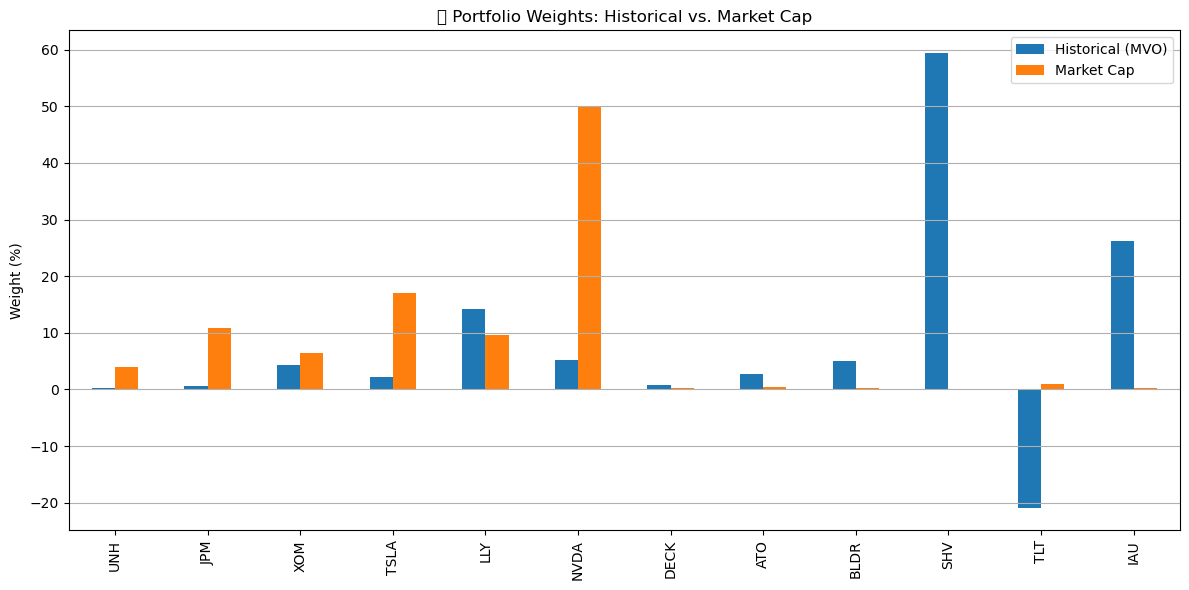

In [177]:
# Compare Portfolio Weights. This shows how your beliefs (historical data) differ from the market consensus.
import matplotlib.pyplot as plt
import pandas as pd

# Asset labels
asset_names = observed_exess_returns.index.tolist()

# Combine weights into DataFrame
weights_df = pd.DataFrame({
    'Historical (MVO)': historical_weight.flatten(),
    'Market Cap': market_weights.flatten()
}, index=asset_names)

# Normalize for comparison (if not already)
weights_df = weights_df.div(weights_df.sum(axis=0), axis=1) * 100  # Convert to %

# Plot
weights_df.plot(kind='bar', figsize=(12, 6))
plt.title("Portfolio Weights: Historical vs. Market Cap")
plt.ylabel("Weight (%)")
plt.grid(axis='y')
plt.tight_layout()
plt.show()


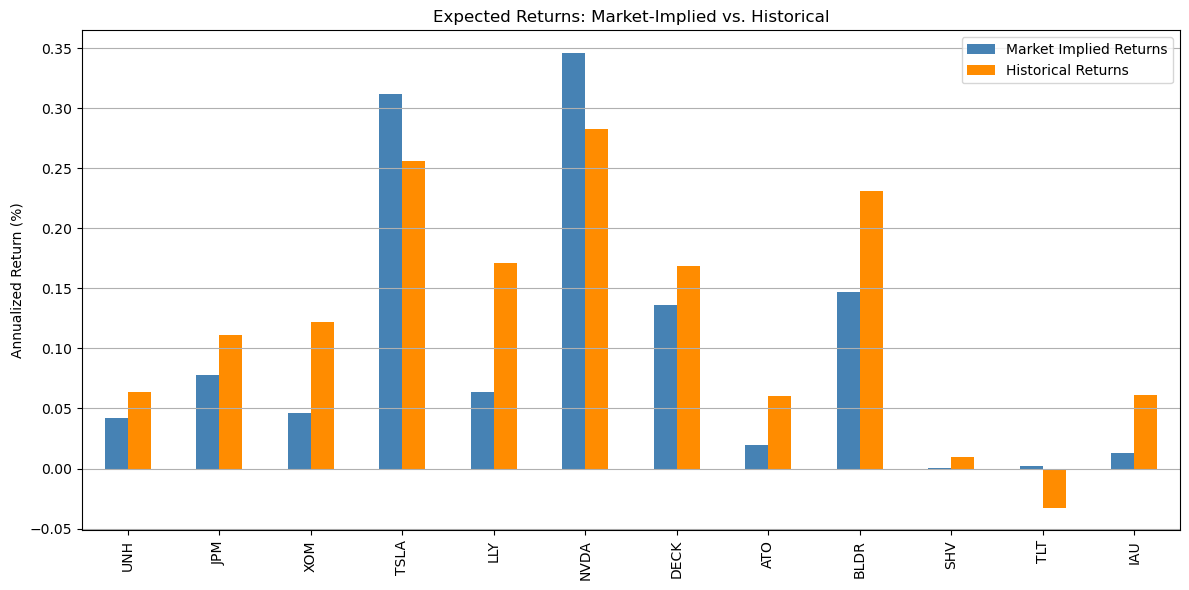

In [179]:
# Compare Implied Returns vs. Historical Returns. This shows how much the market consensus return expectations differ from those implied by history.

# Combine returns into DataFrame
returns_df = pd.DataFrame({
    'Market Implied Returns': market_implied_rets.flatten() * 100,
    'Historical Returns': observed_exess_returns.values * 100  
}, index=asset_names)

# Plot
returns_df.plot(kind='bar', figsize=(12, 6), color=['steelblue', 'darkorange'])
plt.title("Expected Returns: Market-Implied vs. Historical")
plt.ylabel("Annualized Return (%)")
plt.grid(axis='y')
plt.tight_layout()
plt.show()


---

## Mean-Variance optimization approach

$$
\begin{equation*}
\begin{split}
    \underset{w}{\text {argmax}}\: & \mu^T w - \frac{1}{2} \lambda w^T\Sigma w\\
    \text{s.t. } \: & {\bf 1}^T w = 1, \quad w \geq 0 
\end{split}
\end{equation*} 
$$

In [180]:
# Import Scipy
import cvxpy as cp

# Number of assets, (update this to match your actual asset count).
n_assets = 12

# Define the optimization variables
mvo_weight = cp.Variable(n_assets)
risk_aversion = market_risk_aversion

# Define constraints
mvo_constraints = [
    cp.sum(mvo_weight) == 1, ## portfolio fully invested
    mvo_weight >= 0 ## long-only (no shorting)
]

# Define the portfolio
mvo_ret = np.array(observed_exess_returns).reshape(-1,1).T @ mvo_weight #@: matrix multiplication
mvo_vol = cp.quad_form(mvo_weight, cov_matrix) #portfolio variance (quadratic form 𝑤⊤Σ𝑤) 

# Define the problem: the classical Markowitz utility function, balancing reward (returns) vs. penalty (risk)
mvo_problem = cp.Problem(cp.Maximize(mvo_ret - mvo_vol * risk_aversion / 2 ), mvo_constraints)

# Solves the constrained optimization using a convex solver. cvxpy automatically chooses the best solver available.
mvo_problem.solve()

# Get the optimal weights as a NumPy array
mvo_optimal_weights = mvo_weight.value

# Reshapes and formats them as percentages for display.
print("Optimal Weights:")
print(mvo_optimal_weights.reshape(-1,1).round(4)*100) #Only 3–4 assets are getting the majority of the allocation. The rest are essentially not contributing enough expected return vs. risk.
# Why so few assets selected?
# This sparsity is a feature of classic MVO: If asset returns are similar and correlated, MVO tends to concentrate in the "most efficient" ones. If you don’t add regularization or diversification constraints, this is expected behavior.

Optimal Weights:
[[-0.000000]
 [-0.000000]
 [11.230000]
 [8.210000]
 [39.140000]
 [23.570000]
 [0.000000]
 [-0.000000]
 [17.850000]
 [-0.000000]
 [-0.000000]
 [-0.000000]]


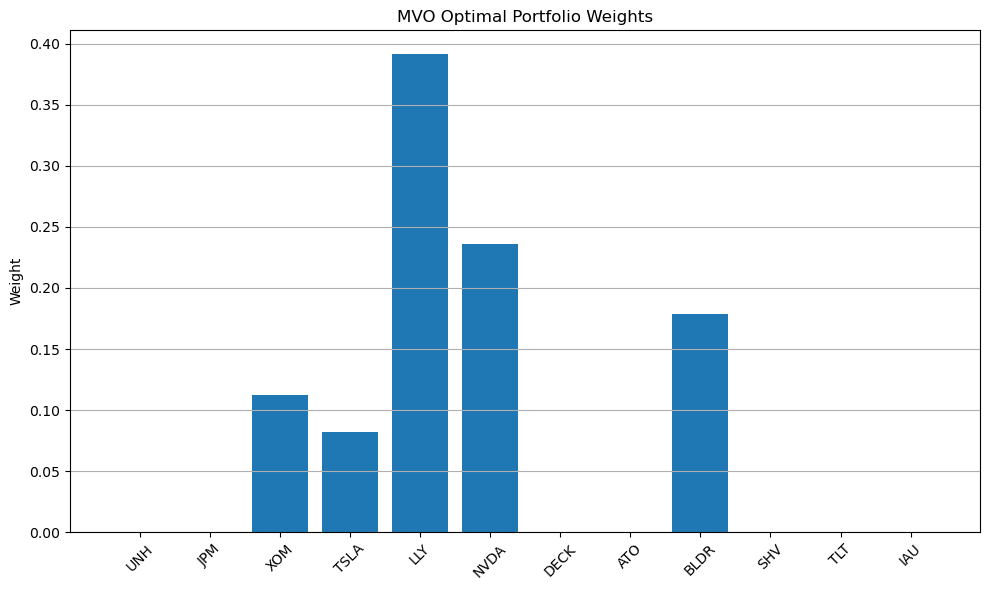

In [181]:
import matplotlib.pyplot as plt

asset_names = observed_exess_returns.index.tolist()
plt.figure(figsize=(10, 6))
plt.bar(asset_names, mvo_optimal_weights)
plt.title("MVO Optimal Portfolio Weights")
plt.ylabel("Weight")
plt.xticks(rotation=45)
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

Create a function to compute the optimal weight for different risk aversion values

In [182]:
def mean_variance_optimization(return_vector, cov_matrix, risk_aversion):
    # Convert input to NumPy array
    if isinstance(return_vector, (pd.Series, pd.DataFrame)):
        return_vector = return_vector.values
    elif not isinstance(return_vector, np.ndarray):
        raise ValueError("Input return_vector must be a NumPy array, Pandas Series, or Pandas DataFrame")

    n_assets = len(return_vector)

    # Define the optimization variables
    mvo_weight = cp.Variable(n_assets)

    # Define constraints
    mvo_constraints = [
        cp.sum(mvo_weight) == 1,
        mvo_weight >= 0
    ]

    # Define the portfolio
    mvo_ret = np.array(return_vector).reshape(-1,1).T @ mvo_weight
    mvo_vol = cp.quad_form(mvo_weight, cov_matrix)

    # Define the objective function
    mvo_objective = cp.Maximize(mvo_ret - risk_aversion * mvo_vol / 2)

    # Define the problem
    mvo_problem = cp.Problem(mvo_objective, mvo_constraints)

    # Solve the problem
    mvo_problem.solve()

    # Get the optimal weights
    mvo_optimal_weights = mvo_weight.value

    return mvo_optimal_weights
mean_variance_optimization(observed_exess_returns, cov_matrix, market_risk_aversion)

array([-0.000000, -0.000000, 0.112318, 0.082063, 0.391410, 0.235667,
       0.000000, -0.000000, 0.178542, -0.000000, -0.000000, -0.000000])

In [183]:
# Compute portfolio annual return
observed_exess_returns*252 @ historical_weight * 100

array([109.673692])

In [184]:
# Compute portfolio risk
historical_weight.T @ cov_matrix *252 @ historical_weight * 100

array([[22.387915]])

---

## Maximize Sharpe Ratio portfolio approach

$$
\begin{equation*}
    \begin{split}
        \underset{w}{\text {argmax}} \; &\frac{\mu^\top w - r_f }{\sqrt{w^\top \Sigma w}} \\\\
        \text{s.t.} \quad   &w^{\top} \mathbf{1} = 1 \\
                            &w \geq 0.    
    \end{split} 
\end{equation*}
$$

In [186]:
# Portfolio Statistics
def portfolio_stats(weights): #computes the Sharpe ratio of a portfolio given a set of weights
    weights = np.array(weights)
    port_rets = weights.T @ np.array(observed_exess_returns) - risk_free_rate.mean()
    port_vols = np.sqrt(multi_dot([weights.T, cov_matrix, weights]))
    return np.array(port_rets/port_vols)
# Maximizing sharpe ratio. We negate it because most optimizers minimize functions, so minimizing negative Sharpe ratio = maximizing Sharpe ratio.
def max_sharpe_ratio(weights):
    return -portfolio_stats(weights)
# Specify constraints, bounds and initial weights
n_assets = len(observed_exess_returns)
cons = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1}) #cons: Sum of weights equals 1 (full investment, no leftover cash).
bnds = tuple((0,1) for x in range(n_assets)) #bnds: Bounds on weights — all weights must be between 0 and 1 (long-only portfolio).
initial_wts = n_assets*[1./n_assets] # start with equal weights
# Optimizing for maximum sharpe ratio. Uses scipy.optimize.minimize to find weights that maximize Sharpe ratio (minimize negative Sharpe ratio).
# Solver: SLSQP — Sequential Least Squares Programming, handles constraints & bounds, good for constrained optimization
opt_sharpe = sco.minimize(max_sharpe_ratio, initial_wts, method='SLSQP', bounds=bnds, constraints=cons)
msr_optimal_weights = opt_sharpe.x
opt_sharpe #Returns the optimization result in opt_sharpe.

     fun: -0.12467114632894442
     jac: array([-0.007559, -0.009290, -0.009235, -0.009079, -0.009127, -0.009071,
       -0.008999, -0.007671, -0.009154, -0.008634, 0.039407, -0.009031])
 message: 'Optimization terminated successfully'
    nfev: 234
     nit: 18
    njev: 18
  status: 0
 success: True
       x: array([0.000000, 0.046729, 0.115908, 0.042978, 0.261769, 0.101088,
       0.012548, 0.000000, 0.075974, 0.000000, 0.000000, 0.343006])

In [187]:
msr_optimal_weights.reshape(-1,1)*100 #Reshaped and multiplied by 100 to express weights in percentage terms.

array([[0.000000],
       [4.672858],
       [11.590815],
       [4.297786],
       [26.176908],
       [10.108846],
       [1.254789],
       [0.000000],
       [7.597414],
       [0.000000],
       [0.000000],
       [34.300583]])

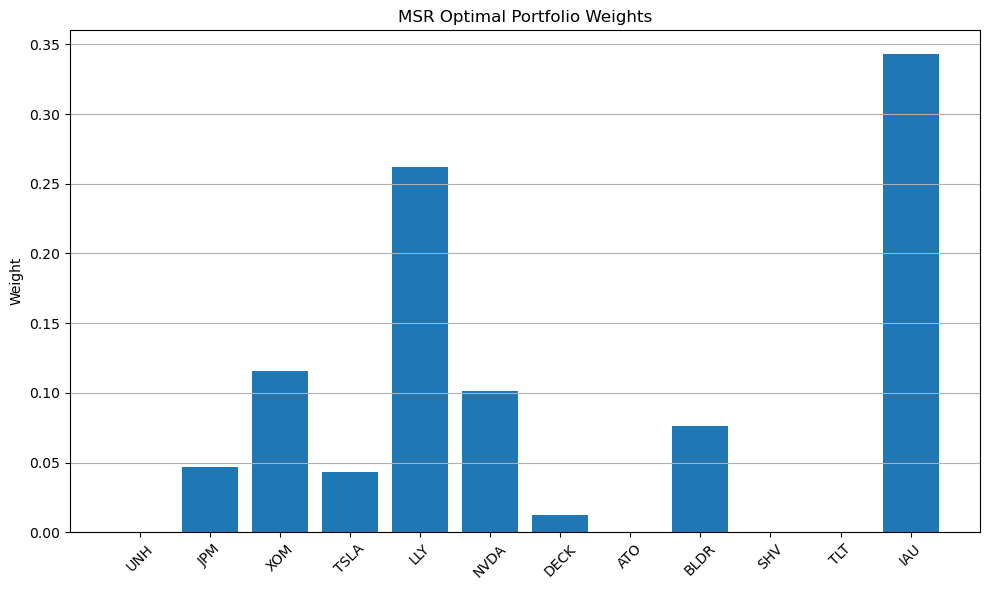

In [188]:
import matplotlib.pyplot as plt

asset_names = observed_exess_returns.index.tolist()
plt.figure(figsize=(10, 6))
plt.bar(asset_names, msr_optimal_weights)
plt.title("MSR Optimal Portfolio Weights")
plt.ylabel("Weight")
plt.xticks(rotation=45)
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

---

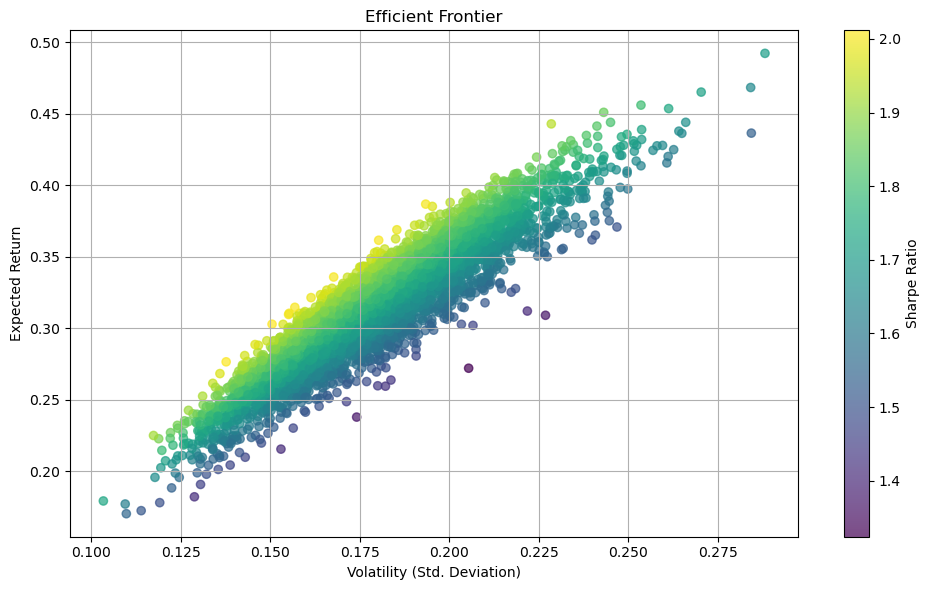

In [189]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from numpy.linalg import multi_dot

# === Simulate Efficient Frontier ===
def simulate_efficient_frontier(expected_returns, cov_matrix, num_portfolios=5000, risk_free_rate=0.0):
    """
    Simulates a large number of random portfolios to estimate the efficient frontier.

    Parameters:
        expected_returns (array-like): Annualized expected returns of assets.
        cov_matrix (np.ndarray): Annualized covariance matrix of asset returns.
        num_portfolios (int): Number of random portfolios to simulate.
        risk_free_rate (float): Annualized risk-free rate for Sharpe ratio calculation.

    Returns:
        results_df (pd.DataFrame): Contains portfolio returns, volatilities, and Sharpe ratios.
        weights_df (pd.DataFrame): Portfolio weights for each simulation.
    """
    n_assets = len(expected_returns)
    results = np.zeros((3, num_portfolios))  # To store returns, volatility, and Sharpe
    weights_record = []  # To store weights for each simulated portfolio

    for i in range(num_portfolios):
        # Randomly generate weights that sum to 1
        weights = np.random.random(n_assets)
        weights /= np.sum(weights)
        weights_record.append(weights)

        # Portfolio return: dot product of weights and expected returns
        port_return = np.dot(weights, expected_returns)

        # Portfolio volatility: sqrt(weights.T * cov_matrix * weights)
        port_volatility = np.sqrt(multi_dot([weights.T, cov_matrix, weights]))

        # Sharpe Ratio calculation
        sharpe_ratio = (port_return - risk_free_rate) / port_volatility

        # Store results
        results[0, i] = port_return
        results[1, i] = port_volatility
        results[2, i] = sharpe_ratio

    # Convert results and weights to DataFrames
    results_df = pd.DataFrame(results.T, columns=['Return', 'Volatility', 'Sharpe'])
    weights_df = pd.DataFrame(weights_record, columns=expected_returns.index if hasattr(expected_returns, 'index') else [f'Asset {i}' for i in range(n_assets)])
    
    return results_df, weights_df


# === Plot Efficient Frontier ===
def plot_efficient_frontier(results_df, title="Efficient Frontier"):
    """
    Plots the efficient frontier using simulated portfolio results.

    Parameters:
        results_df (pd.DataFrame): Contains 'Return', 'Volatility', and 'Sharpe' columns.
        title (str): Title of the plot.
    """
    plt.figure(figsize=(10, 6))

    # Scatter plot: Volatility (x-axis) vs Return (y-axis), color by Sharpe ratio
    plt.scatter(results_df['Volatility'], results_df['Return'],
                c=results_df['Sharpe'], cmap='viridis', alpha=0.7)

    plt.xlabel('Volatility (Std. Deviation)')
    plt.ylabel('Expected Return')
    plt.colorbar(label='Sharpe Ratio')  # Colorbar shows the Sharpe scale
    plt.title(title)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

expected_returns = observed_exess_returns * 252  # Ensure returns are annualized
annual_cov_matrix = cov_matrix * 252             # Ensure covariance matrix is annualized
# Convert from percentage to decimal
rf_daily = famafrench_model.RF / 100
# Compute average daily risk-free rate
rf_mean_daily = rf_daily.mean()
# Annualize (assuming 252 trading days/year)
rf_mean_annual = rf_mean_daily * 252
results_df, weights_df = simulate_efficient_frontier(expected_returns, annual_cov_matrix, risk_free_rate=rf_mean_annual)
plot_efficient_frontier(results_df)


In [192]:
expected_returns
# Tech & Growth (NVDA, TSLA, BLDR, DECK):
# These have been strong outperformers — TSLA and NVDA especially. A 60–70% return is high but not implausible for NVDA or TSLA in recent rallies.
# Pharma & Healthcare (LLY, UNH):
# LLY has been a mega-cap outperformer. UNH's 16% is healthy and consistent with steady growth.
# Energy (XOM):
# A ~30% excess return for ExxonMobil is consistent with periods of high oil prices.
# Financials (JPM):
# A ~28% excess return may reflect rate cycle benefits, strong balance sheet, and sector rotation.
# Utilities (ATO):
# More defensive; 15% excess return is on the upper end but not unreasonable.
# Gold (IAU) and Bonds (TLT):
# IAU (gold): ~15% excess return is plausible given rising inflation/hedging.
# TLT (long-term Treasuries): Negative return of -8.2% is expected in a rising rate environment.
# SHV (short-term Treasury ETF): Small but positive return, also expected.

UNH     0.16041
JPM     0.27980
XOM     0.30655
TSLA    0.64517
LLY     0.43118
NVDA    0.71249
DECK    0.42473
ATO     0.15182
BLDR    0.58272
SHV     0.02385
TLT    -0.08212
IAU     0.15486
dtype: float64

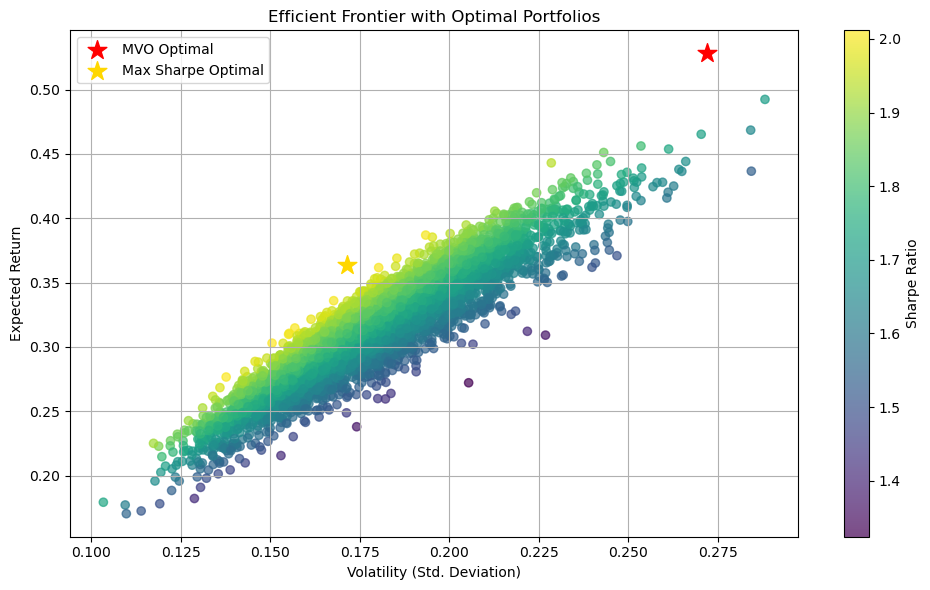

In [193]:
# Calculate your optimized portfolios’ stats
def portfolio_perf(weights, expected_returns, cov_matrix):
    ret = np.dot(weights, expected_returns)
    vol = np.sqrt(multi_dot([weights.T, cov_matrix, weights]))
    sharpe = (ret - rf_mean_annual) / vol
    return ret, vol, sharpe

# MVO optimal stats
mvo_ret, mvo_vol, mvo_sharpe = portfolio_perf(mvo_optimal_weights, expected_returns, annual_cov_matrix)

# MSR optimal stats
msr_ret, msr_vol, msr_sharpe = portfolio_perf(msr_optimal_weights, expected_returns, annual_cov_matrix)

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(results_df['Volatility'], results_df['Return'], c=results_df['Sharpe'], cmap='viridis', alpha=0.7)
plt.colorbar(label='Sharpe Ratio')

# Overlay your optimized portfolios
plt.scatter(mvo_vol, mvo_ret, marker='*', color='r', s=200, label='MVO Optimal')
plt.scatter(msr_vol, msr_ret, marker='*', color='gold', s=200, label='Max Sharpe Optimal')

plt.xlabel('Volatility (Std. Deviation)')
plt.ylabel('Expected Return')
plt.title('Efficient Frontier with Optimal Portfolios')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


---

## BL Implememt

### Building the Inputs

Traditional Mean-Variance Optimization (MVO) requires you to input:
Expected returns (mu); Covariance matrix (Sigma); Risk aversion level (delta)
But: Estimating mu accurately is very hard. Small changes in mu → big changes in portfolio weights (instability).

Black-Litterman provides a more stable and intuitive way to estimate expected returns. It blends:
Implied market returns — what returns would have to be if the market were "correct" (from CAPM).
Investor views — your personal beliefs about how some assets might perform.
It adjusts the market-implied returns based on your views and their confidence, and uses the resulting returns in MVO.

In [201]:
# tau: Scalar that scales the uncertainty in the prior estimate of the covariance matrix. It controls how much confidence we put in the prior (market equilibrium) vs. the views. 
# P: The view matrix — each row corresponds to one view.
# Q: The view returns vector — the expected returns for each view, here adjusted to daily returns by dividing by 252 (trading days per year).
import numpy as np
# assets = ['UNH', 'JPM', 'XOM', 'TSLA', 'LLY', 'NVDA', 'DECK', 'ATO', 'BLDR', 'SHV', 'TLT', 'IAU']
# View matrix P (4 views total)
P = np.array([
    [ 0,  0,  0, -1,  0,  1,  0,  0,  0,  0,  0,  0],  # View 1: NVDA - TSLA = +3%
    [ 0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0],  # View 2: BLDR = 60%
    [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  1],  # View 3: IAU - TLT = +2%
    [ 0,  0,  0, 1/3,  0, 1/3, 1/3, 0,  0, -1/3, -1/3, -1/3]  # View 4: Growth vs. Defensive = +5%
])

# View returns Q
Q = np.array([
    0.03 / 252,   # NVDA - TSLA = +3% annually
    0.60 / 252,   # BLDR = 60% annually
    0.02 / 252,   # IAU - TLT = +2% annually
    0.05 / 252    # Growth vs. Defensive = +5% annually
]).reshape(-1, 1)

tau = 0.05 #A scalar (typically small, e.g., 0.025–0.1). Controls how much weight to place on the market equilibrium returns (π). Affects how much π is shrunk toward the investor's views.
#Intuition: Lower tau → more trust in market → more conservative views. Higher tau → less trust in market → investor views dominate.

In [202]:
pd.options.display.float_format = '{:,.5f}'.format
pd.DataFrame(cov_matrix)

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.00030,0.00007,0.00006,0.00008,0.00006,0.00008,0.00007,0.00006,0.00010,-0.00000,-0.00000,0.00001
1,0.00007,0.00032,0.00017,0.00018,0.00005,0.00015,0.00017,0.00008,0.00022,-0.00000,-0.00004,-0.00000
2,0.00006,0.00017,0.00040,0.00007,0.00005,0.00006,0.00011,0.00008,0.00017,-0.00000,-0.00004,0.00002
3,0.00008,0.00018,0.00007,0.00165,0.00007,0.00064,0.00034,0.00004,0.00038,-0.00000,0.00001,0.00003
4,0.00006,0.00005,0.00005,0.00007,0.00040,0.00014,0.00009,0.00005,0.00008,0.00000,0.00001,0.00001
5,0.00008,0.00015,0.00006,0.00064,0.00014,0.00112,0.00036,0.00002,0.00037,0.00000,0.00002,0.00004
6,0.00007,0.00017,0.00011,0.00034,0.00009,0.00036,0.00072,0.00005,0.00038,-0.00000,0.00000,0.00002
7,0.00006,0.00008,0.00008,0.00004,0.00005,0.00002,0.00005,0.00019,0.00010,0.00000,0.00001,0.00002
8,0.00010,0.00022,0.00017,0.00038,0.00008,0.00037,0.00038,0.00010,0.00094,0.00000,0.00003,0.00003
9,-0.00000,-0.00000,-0.00000,-0.00000,0.00000,0.00000,-0.00000,0.00000,0.00000,0.00001,0.00000,0.00000


In [203]:
# Compute Omega matrix which measures the uncertainty (variance) of the views. Each value of Ω[i, i] represents the variance of the view (i.e., the squared uncertainty) derived from how risky the view is under the model's current beliefs.
# If you’re very confident in a view, Ω should be small → the model will lean more heavily on your input. If you’re less confident, Ω should be large → the model will mostly rely on the market consensus instead.
Omega = np.matmul(np.matmul(P, cov_matrix), P.T)
Omega = np.diag(np.diag(Omega))
Omega

array([[0.001488, 0.000000, 0.000000, 0.000000],
       [0.000000, 0.000937, 0.000000, 0.000000],
       [0.000000, 0.000000, 0.000158, 0.000000],
       [0.000000, 0.000000, 0.000000, 0.000691]])

In [208]:
#If you want to override model-derived omega, you can manually specify it based on your confidence level
omega_manual = np.diag([
    0.00001,  # Very high confidence in view 1
    0.0001,   # Moderate confidence in view 2
    0.0002,   # Lower confidence in view 3
    0.00005   # Strong confidence in view 4
])

$$
\mathbb{E}(r) = \mu_\text{BL} = \left[ (\tau\Sigma)^{-1} + P^\top \Omega^{-1} P \right]^{-1} \left[ (\tau\Sigma)^{-1} \Pi + P^\top \Omega^{-1} Q \right]
$$

In [204]:
# Compute the first half of the equation
tauSigmainv = np.linalg.inv(tau*cov_matrix) 
first_half = np.linalg.inv(tauSigmainv +  P.T @ np.linalg.inv(Omega) @ P)

# Compute the second half of the equation
second_half = (tauSigmainv @ market_implied_rets).reshape(-1,1) + P.T @ np.linalg.inv(Omega) @ Q

# New combined return vector. First half and second half combine the market prior and the investor views. This produces the posterior expected returns, a compromise between market and personal views.
combined_return_vector = first_half @ second_half

combined_return_vector

array([[0.000410],
       [0.000757],
       [0.000455],
       [0.003001],
       [0.000624],
       [0.003358],
       [0.001299],
       [0.000196],
       [0.001460],
       [0.000001],
       [0.000029],
       [0.000134]])

In [205]:
# Compute updated weight. 
blm_weights = np.matmul(np.linalg.inv(market_risk_aversion * cov_matrix), combined_return_vector).flatten()
blm_weights.round(4)*100

array([3.980000, 10.820000, 6.520000, 16.040000, 9.560000, 48.710000,
       -0.900000, 0.360000, 1.180000, 1.270000, 2.190000, 1.260000])

Create a Black-Litterman class to compute the weight with specified inputs

In [206]:
import numpy as np
import pandas as pd

class BlackLittermanModel:
    def __init__(
        self,
        market_weights: np.ndarray,
        cov_matrix: np.ndarray,
        P: np.ndarray,
        Q: np.ndarray,
        tau: float = 0.05,
        risk_aversion: float = 4.1,
        omega: np.ndarray = None
    ):
        """
        Initializes the Black-Litterman model.

        Parameters:
        - market_weights: (n_assets,) array of market cap weights
        - cov_matrix: (n_assets, n_assets) covariance matrix
        - P: (n_views, n_assets) matrix representing the views
        - Q: (n_views, 1) vector of view returns
        - tau: scalar controlling weight of prior (default: 0.05)
        - risk_aversion: scalar risk aversion coefficient (default: 4.1)
        - omega: optional (n_views, n_views) view uncertainty matrix. If None, it is calculated.
        """
        self.market_weights = market_weights.reshape(-1, 1)
        self.cov_matrix = cov_matrix
        self.P = P
        self.Q = Q.reshape(-1, 1)
        self.tau = tau
        self.risk_aversion = risk_aversion

        self._validate_inputs()

        self.omega = omega if omega is not None else self._calculate_omega()

    def _validate_inputs(self):
        n_assets = self.cov_matrix.shape[0]
        if self.market_weights.shape[0] != n_assets:
            raise ValueError("Market weights must match the number of assets.")
        if self.P.shape[1] != n_assets:
            raise ValueError("View matrix P must have the same number of columns as assets.")
        if self.P.shape[0] != self.Q.shape[0]:
            raise ValueError("The number of views (rows in P) must match the number of elements in Q.")

    def _calculate_omega(self) -> np.ndarray:
        """
        Calculates a diagonal Omega matrix assuming independent view uncertainties.
        """
        view_cov = self.P @ (self.tau * self.cov_matrix) @ self.P.T
        return np.diag(np.diag(view_cov))

    def implied_returns(self) -> np.ndarray:
        """
        Calculates the implied equilibrium returns π = λ * Σ * w_mkt
        """
        return self.risk_aversion * self.cov_matrix @ self.market_weights

    def combined_returns(self) -> np.ndarray:
        """
        Computes the posterior (BL) expected returns.
        """
        pi = self.implied_returns()

        # Intermediate calculations
        tau_sigma_inv = np.linalg.inv(self.tau * self.cov_matrix)
        omega_inv = np.linalg.inv(self.omega)
        middle_term = self.P.T @ omega_inv @ self.P

        # Posterior mean
        posterior_mean = np.linalg.inv(tau_sigma_inv + middle_term) @ (
            tau_sigma_inv @ pi + self.P.T @ omega_inv @ self.Q
        )

        return posterior_mean

    def bl_weights(self) -> np.ndarray:
        """
        Computes the BL optimal portfolio weights using the combined expected returns
        Solve for the optimal portfolio weights using the classic mean-variance formula:
        # w* = (1/λ) * Σ⁻¹ * μ
        # where:
        #   λ = risk aversion coefficient
        #   Σ = covariance matrix of asset returns
        #   μ = vector of expected excess returns (from BL posterior)
        # This finds the weights that maximize expected return per unit of risk.
        np.linalg.solve(A, b) solves the linear system A * x = b
        # This is numerically more stable and efficient than directly computing the inverse:
        # x = A⁻¹ * b
        # Avoiding matrix inversion reduces numerical errors and improves performance.
        """
        bl_returns = self.combined_returns()
        weights = np.linalg.solve(self.risk_aversion * self.cov_matrix, bl_returns)
        return weights.flatten()

    def summary(self) -> pd.DataFrame:
        """
        Returns a summary dataframe of combined expected returns and portfolio weights.
        """
        return pd.DataFrame({
            "Combined Returns": self.combined_returns().flatten(),
            "BL Weights (%)": self.bl_weights() * 100
        })

# BL Weights
bl_model = BlackLittermanModel(
    market_weights=market_weights,
    cov_matrix=cov_matrix,
    P=P,
    Q=Q,
    tau=0.05,
    risk_aversion=market_risk_aversion
)
bl_weights = bl_model.bl_weights().reshape(-1, 1)
bl_weights

array([[0.039846],
       [0.108234],
       [0.065196],
       [0.074040],
       [0.095560],
       [0.326406],
       [-0.132485],
       [0.003611],
       [0.177666],
       [0.136239],
       [0.129397],
       [0.152181]])

In [207]:
bl_returns = bl_model.combined_returns()
bl_returns #Black-Litterman expected returns are forward-looking estimates, depending on the frequency of cov_matrix,observed_excess_returns and your views Q (scaled daily in this case)

array([[0.000352],
       [0.000621],
       [0.000443],
       [0.001924],
       [0.000511],
       [0.002326],
       [0.000760],
       [0.000240],
       [0.001574],
       [0.000006],
       [0.000117],
       [0.000185]])

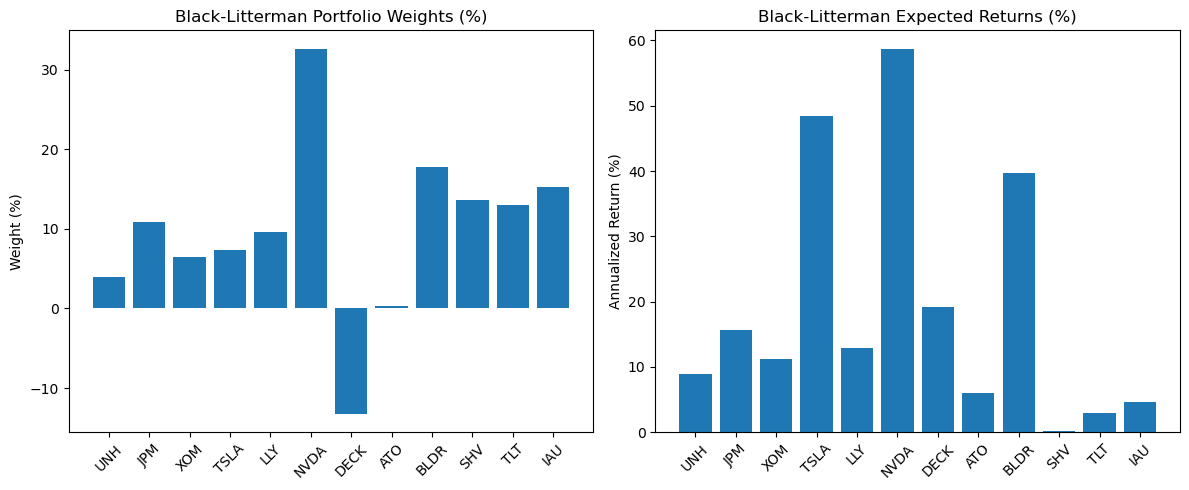

In [211]:
import matplotlib.pyplot as plt

assets = ['UNH', 'JPM', 'XOM', 'TSLA', 'LLY', 'NVDA', 'DECK', 'ATO', 'BLDR', 'SHV', 'TLT', 'IAU']

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.bar(assets, bl_weights.flatten()*100)
plt.title('Black-Litterman Portfolio Weights (%)')
plt.xticks(rotation=45)
plt.ylabel('Weight (%)')

plt.subplot(1,2,2)
plt.bar(assets, bl_returns.flatten()*252*100)  # annualized return %
plt.title('Black-Litterman Expected Returns (%)')
plt.xticks(rotation=45)
plt.ylabel('Annualized Return (%)')

plt.tight_layout()
plt.show()


---


Portfolio Performance Comparison (Including Benchmark):
                     Annual Return (%)  Annual Volatility (%)  Sharpe Ratio
Market Cap                    56.62300               35.56300       1.59200
MVO                          109.67400               47.31600       2.31800
MSR                           36.39500               17.13800       2.12300
Black-Litterman               44.21900               25.70600       1.72000
Benchmark (S&P 500)           19.19100               18.47100       1.03800


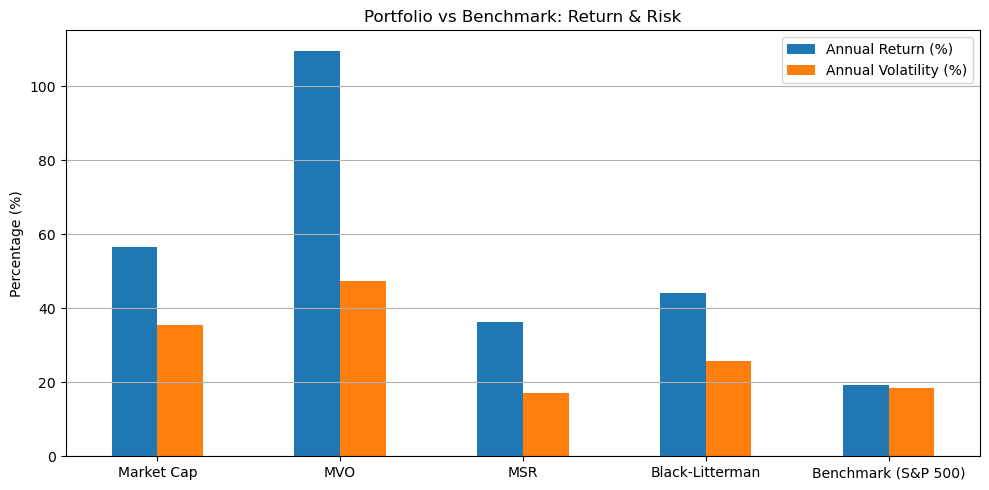

In [212]:
from numpy.linalg import solve, multi_dot

# --- Portfolio Performance Metrics ---
def portfolio_performance(weights, excess_returns, cov_matrix, risk_free_rate):
    weights = weights.reshape(-1, 1)
    ann_return = 252 * (excess_returns.T @ weights).item()
    ann_vol = np.sqrt(252 * (weights.T @ cov_matrix @ weights)).item()
    sharpe = (ann_return - risk_free_rate.mean()) / ann_vol
    return ann_return * 100, ann_vol * 100, sharpe

# --- Market Cap Weights ---
market_weights = market_weights.reshape(-1, 1)

# --- MVO Weights ---
mvo_weights = solve(market_risk_aversion * cov_matrix, observed_exess_returns.values.reshape(-1, 1))

# --- MSR Weights (already optimized) ---
msr_weights = msr_optimal_weights.reshape(-1, 1)

# --- Benchmark (e.g., S&P 500) Stats ---
sp500_daily_returns = sp500.pct_change().dropna()
benchmark_return = sp500_daily_returns.mean() * 252 * 100  # in %
benchmark_vol = sp500_daily_returns.std() * np.sqrt(252) * 100  # in %
benchmark_sharpe = (benchmark_return - risk_free_rate.mean() * 100) / benchmark_vol

# --- Compile Results ---
results = {
    "Market Cap": portfolio_performance(market_weights, observed_exess_returns, cov_matrix, risk_free_rate),
    "MVO": portfolio_performance(mvo_weights, observed_exess_returns, cov_matrix, risk_free_rate),
    "MSR": portfolio_performance(msr_weights, observed_exess_returns, cov_matrix, risk_free_rate),
    "Black-Litterman": portfolio_performance(bl_weights, observed_exess_returns, cov_matrix, risk_free_rate),
    "Benchmark (S&P 500)": (benchmark_return, benchmark_vol, benchmark_sharpe)
}

# --- Display Table ---
performance_df = pd.DataFrame(results, index=["Annual Return (%)", "Annual Volatility (%)", "Sharpe Ratio"]).T
print("\nPortfolio Performance Comparison (Including Benchmark):")
print(performance_df.round(3))

# --- Bar Plot (Returns & Volatility) ---
performance_df[["Annual Return (%)", "Annual Volatility (%)"]].plot(kind='bar', figsize=(10, 5), rot=0)
plt.title("Portfolio vs Benchmark: Return & Risk")
plt.ylabel("Percentage (%)")
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()



🔍 Full Portfolio Performance & Risk Metrics:
                 Annual Return (%)  Annual Volatility (%)  Sharpe Ratio  \
Market Cap                56.62260               35.56270       1.52250   
MVO                      109.67370               47.31590       2.26550   
MSR                       36.39470               17.13770       1.97910   
Black-Litterman           44.21940               25.70550       1.62380   

                 VaR 5% (daily)  Max Drawdown  
Market Cap             -0.03510      -0.75870  
MVO                    -0.04360      -0.56000  
MSR                    -0.01600      -0.46090  
Black-Litterman        -0.02420      -0.86300  


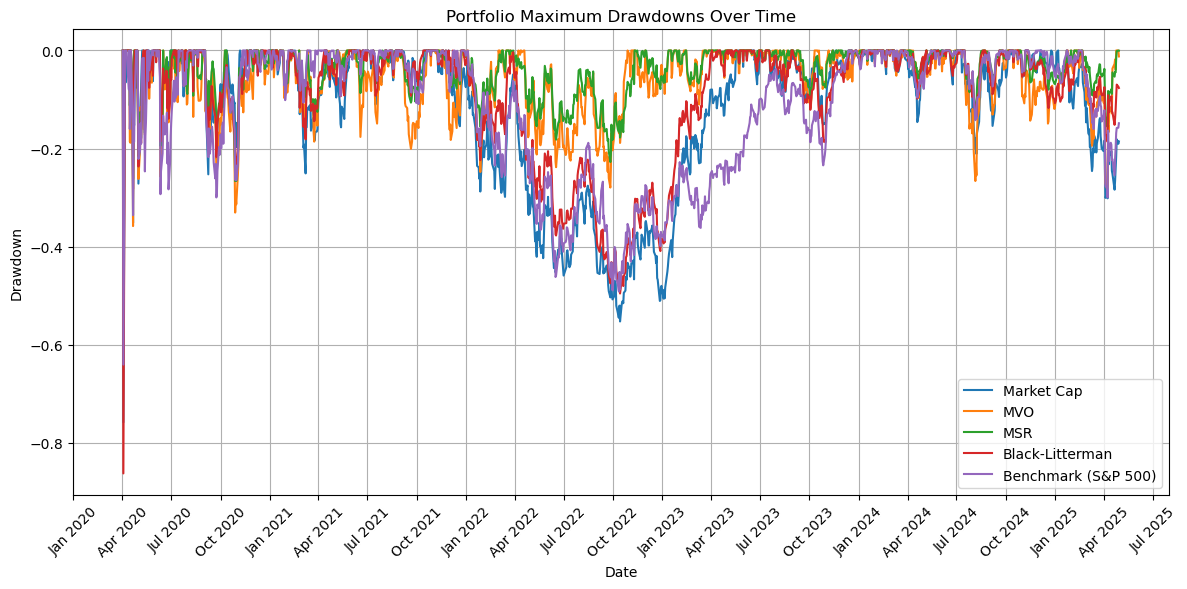

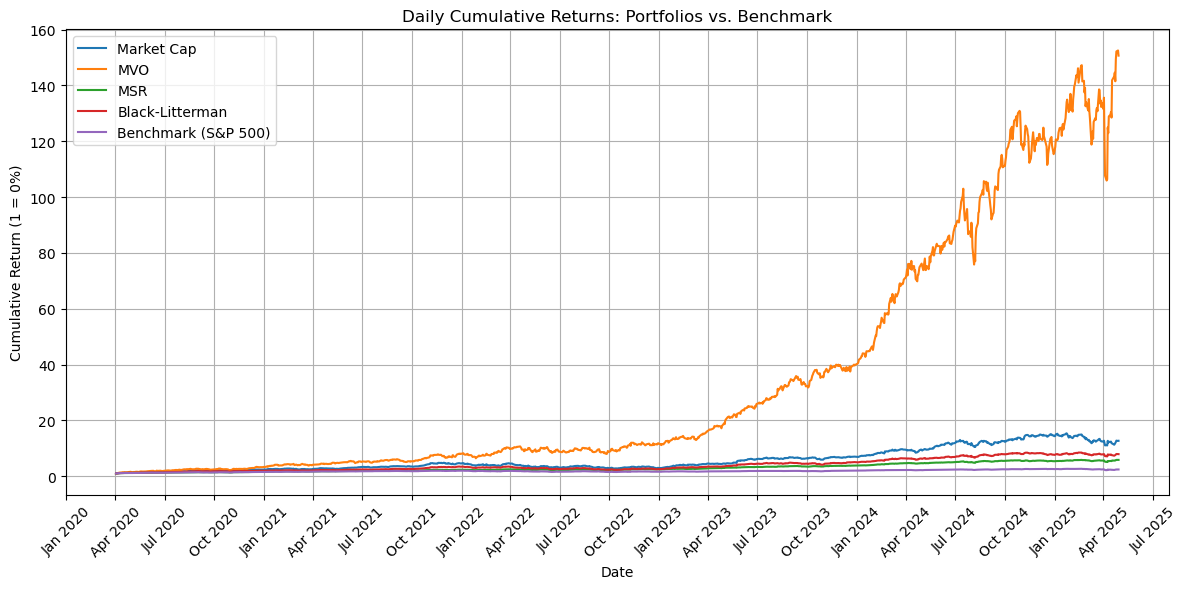

In [238]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# --- Portfolio Performance Metrics ---
def portfolio_performance(weights, excess_returns, cov_matrix, risk_free_rate):
    weights = weights.reshape(-1, 1)
    ann_return = 252 * (excess_returns.T @ weights).item()
    ann_vol = np.sqrt(252 * (weights.T @ cov_matrix @ weights)).item()
    sharpe = (ann_return - risk_free_rate.mean() * 252) / ann_vol
    return ann_return * 100, ann_vol * 100, sharpe

# --- Risk Metrics ---
def calculate_var(returns, confidence_level=0.05):
    return np.percentile(returns, 100 * confidence_level)

def calculate_max_drawdown(cum_returns):
    running_max = np.maximum.accumulate(cum_returns)
    drawdowns = (cum_returns - running_max) / running_max
    return drawdowns.min()

# --- Calculate Annualized Performance ---
results = {
    "Market Cap": portfolio_performance(market_weights, observed_exess_returns, cov_matrix, risk_free_rate),
    "MVO": portfolio_performance(mvo_weights, observed_exess_returns, cov_matrix, risk_free_rate),
    "MSR": portfolio_performance(msr_weights, observed_exess_returns, cov_matrix, risk_free_rate),
    "Black-Litterman": portfolio_performance(bl_weights, observed_exess_returns, cov_matrix, risk_free_rate)
}

performance_df = pd.DataFrame(results, index=["Annual Return (%)", "Annual Volatility (%)", "Sharpe Ratio"]).T

# --- Daily Portfolio Returns ---
portfolio_returns = {}
for name, weights in zip(results.keys(), [market_weights, mvo_weights, msr_weights, bl_weights]):
    w = weights.flatten()
    portfolio_returns[name] = filtered_daily_ret.dot(w)

# Add S&P 500 Benchmark
portfolio_returns["Benchmark (S&P 500)"] = sp500.pct_change().dropna()

# --- VaR and Max Drawdown ---
var_dict = {}
max_dd_dict = {}

for name, rets in portfolio_returns.items():
    cum_rets = (1 + rets).cumprod() - 1
    var_dict[name] = calculate_var(rets)
    max_dd_dict[name] = calculate_max_drawdown(cum_rets)

risk_metrics_df = pd.DataFrame({
    "VaR 5% (daily)": pd.Series(var_dict),
    "Max Drawdown": pd.Series(max_dd_dict)
})

# --- Combine Performance and Risk Metrics ---
full_metrics_df = performance_df.join(risk_metrics_df)
print("\n🔍 Full Portfolio Performance & Risk Metrics:")
print(full_metrics_df.round(4))

# --- Plot 1: Drawdowns ---
plt.figure(figsize=(12, 6))
for name, rets in portfolio_returns.items():
    cum_rets = (1 + rets).cumprod() - 1
    drawdowns = (cum_rets - np.maximum.accumulate(cum_rets)) / np.maximum.accumulate(cum_rets)
    drawdown_dates = pd.to_datetime(drawdowns.index)
    plt.plot(drawdown_dates, drawdowns.values, label=name)

plt.gca().xaxis.set_major_locator(mdates.MonthLocator(bymonth=[1, 4, 7, 10]))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.xticks(rotation=45)
plt.title("Portfolio Maximum Drawdowns Over Time")
plt.ylabel("Drawdown")
plt.xlabel("Date")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Plot 2: Cumulative Returns ---
plt.figure(figsize=(12, 6))
for name, rets in portfolio_returns.items():
    cum_rets = (1 + rets).cumprod()
    cum_rets.index = pd.to_datetime(cum_rets.index)
    plt.plot(cum_rets.index, cum_rets.values, label=name)

plt.gca().xaxis.set_major_locator(mdates.MonthLocator(bymonth=[1, 4, 7, 10]))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.xticks(rotation=45)
plt.title("Daily Cumulative Returns: Portfolios vs. Benchmark")
plt.ylabel("Cumulative Return (1 = 0%)")
plt.xlabel("Date")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


MVO can appear to outperform because: “It’s the most optimistic model — but also the most naive.” Its simplicity can be dangerous without regularization, robust return forecasts, or diversification constraints.
| Model               | Comment
| **Market Cap**      | Reflects broader market, more stable but diluted                        
| **MSR**             | Tries to maximize Sharpe Ratio, but is *less extreme* than MVO (more risk-controlled).
| **Black-Litterman** | Blends your historical views with market consensus — often dampening extreme bets like MVO makes
1. MVO Is Fully Return-Driven
MVO uses sample mean excess returns as expected returns.
These inputs are forward-looking in-sample, and it doesn't second-guess them.
If your historical daily returns (e.g., NVDA, TSLA, BLDR) are very high, MVO will pour money into them — regardless of stability or future plausibility.
2. Overfitting to In-Sample Data
MVO often "chases winners" — it overweights the highest-returning assets, even if that success was due to random luck.
If this is a backtest, it's likely overfit. MVO does not handle estimation error well.
3. No Diversification Penalization
Your MVO is likely highly concentrated (check the number of non-zero weights).
It doesn’t penalize correlation or promote diversification unless explicitly told.
4. Time Window May Favor Growth/Tech
Your backtest includes 2020–2025 — a high-growth era for NVDA, TSLA, BLDR, etc.
MVO likely concentrated in those (check the weights).
That makes it look spectacular in hindsight, but may not hold in new data.

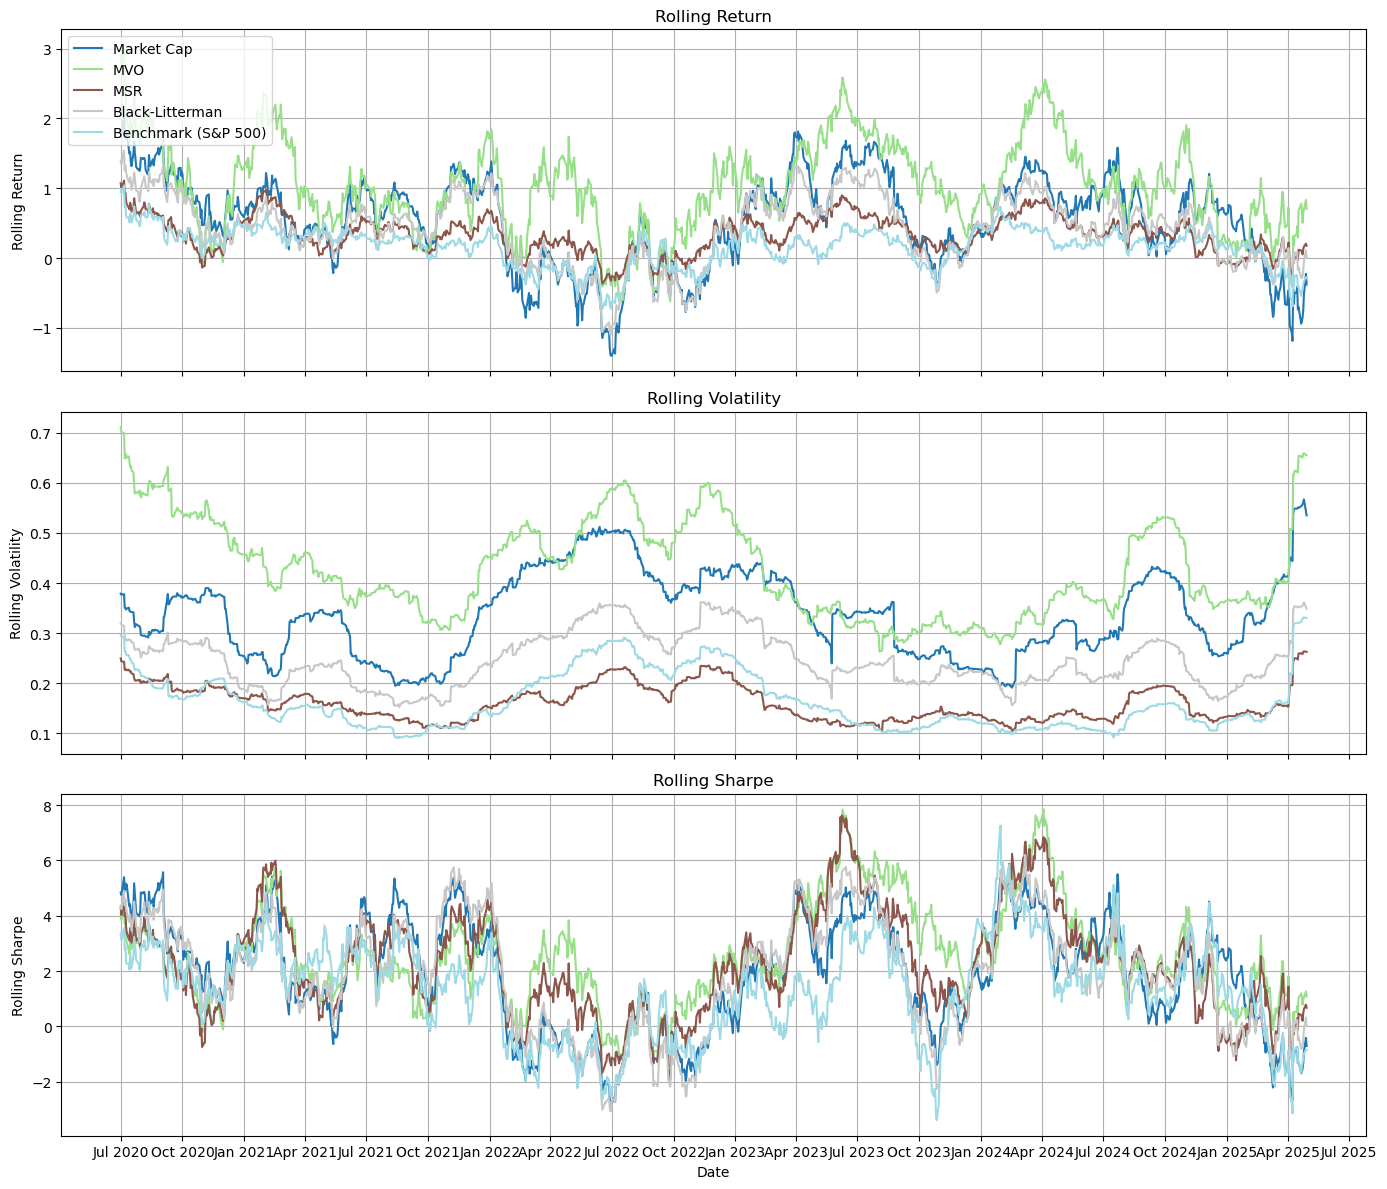

In [243]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# --- Rolling Metrics ---
window = 63  # Approx. 3-month window (63 trading days)

rolling_metrics = {}

# Calculate rolling annualized return, volatility, Sharpe
for name, rets in portfolio_returns.items():
    roll_ret = rets.rolling(window).mean() * 252
    roll_vol = rets.rolling(window).std() * np.sqrt(252)
    roll_sharpe = roll_ret / roll_vol
    rolling_metrics[name] = {
        'Rolling Return': roll_ret,
        'Rolling Volatility': roll_vol,
        'Rolling Sharpe': roll_sharpe
    }

# --- Plotting Rolling Metrics ---
fig, axs = plt.subplots(3, 1, figsize=(14, 12), sharex=True)

colors = plt.cm.get_cmap('tab20', len(portfolio_returns))

for i, metric in enumerate(['Rolling Return', 'Rolling Volatility', 'Rolling Sharpe']):
    ax = axs[i]
    for j, (name, metrics) in enumerate(rolling_metrics.items()):
        metrics[metric].index = pd.to_datetime(metrics[metric].index)
        ax.plot(metrics[metric].index, metrics[metric].values, label=name, color=colors(j))
    ax.set_title(metric)
    ax.set_ylabel(metric)
    ax.grid(True)

    if i == 2:
        ax.set_xlabel("Date")
    if i == 0:
        ax.legend(loc='upper left')

    # Format x-axis with quarterly ticks & custom formatter
    ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1,4,7,10)))  # Jan, Apr, Jul, Oct
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y')) 

plt.tight_layout()
plt.show()


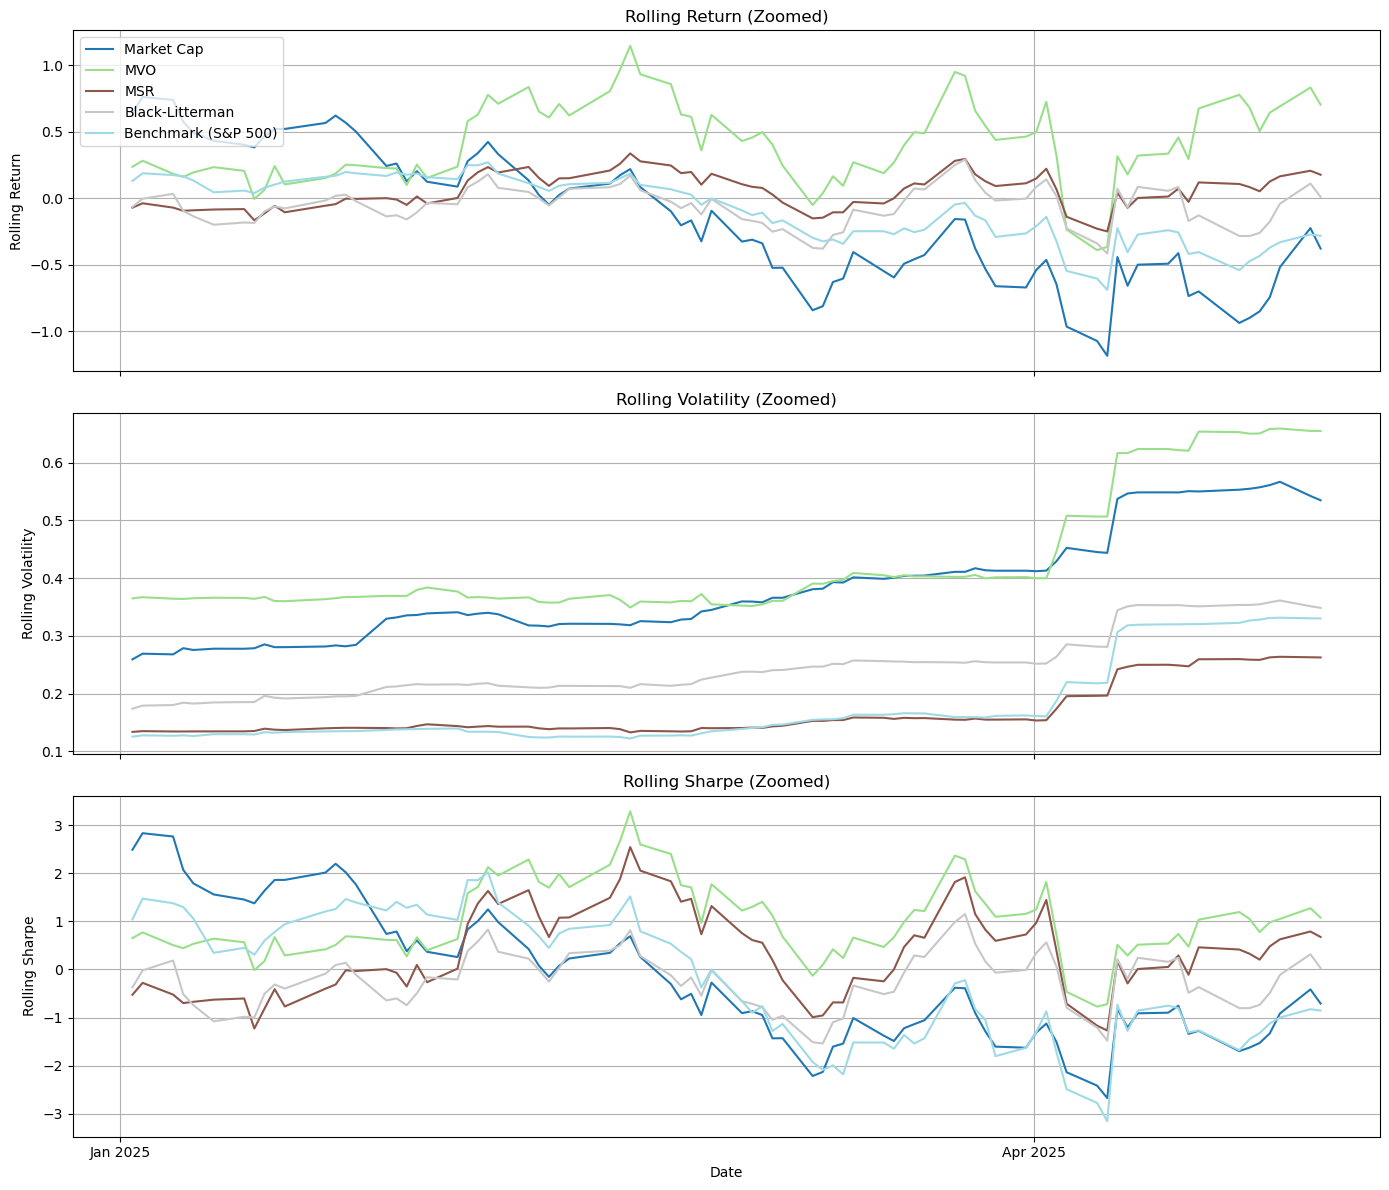

In [264]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

def plot_rolling_metrics_zoom(rolling_metrics, start, end):
    """
    Plots rolling return, volatility, and Sharpe ratio for the specified date range.

    Parameters:
    - rolling_metrics: dict of dicts, output from your rolling metrics calculation
    - start: str or pd.Timestamp, start date of zoom window (e.g., '2022-01-01')
    - end: str or pd.Timestamp, end date of zoom window (e.g., '2022-06-30')
    """
    # Convert start/end to Timestamp
    start = pd.to_datetime(start).tz_localize('UTC')
    end = pd.to_datetime(end).tz_localize('UTC')

    fig, axs = plt.subplots(3, 1, figsize=(14, 12), sharex=True)
    colors = plt.cm.get_cmap('tab20', len(rolling_metrics))

    for i, metric in enumerate(['Rolling Return', 'Rolling Volatility', 'Rolling Sharpe']):
        ax = axs[i]
        for j, (name, metrics) in enumerate(rolling_metrics.items()):
            # Filter data by date window
            filtered_data = metrics[metric].loc[start:end]
            ax.plot(filtered_data.index, filtered_data.values, label=name, color=colors(j))

        ax.set_title(f'{metric} (Zoomed)')
        ax.set_ylabel(metric)
        ax.grid(True)
        if i == 2:
            ax.set_xlabel('Date')
        if i == 0:
            ax.legend(loc='upper left')
        ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1,4,7,10)))  # Jan, Apr, Jul, Oct
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y')) 

    plt.tight_layout()
    plt.show()
plot_rolling_metrics_zoom(rolling_metrics, '2025-01-01', '2025-04-30')


---

## Different Risk Aversion Levels

In [224]:
# Create 3 different risk aversion levels
risk_seeking = 1
risk_neutral = market_risk_aversion  # likely defined earlier as the market's average risk tolerance
risk_averse = 10
# weight allocation for risk seeking investors
mean_variance_optimization(observed_exess_returns, cov_matrix, risk_seeking).round(4)*100

array([-0.000000, 0.000000, -0.000000, 9.580000, -0.000000, 76.380000,
       0.000000, 0.000000, 14.040000, -0.000000, -0.000000, -0.000000])

In [225]:
# weight allocation for risk neutral investors
mean_variance_optimization(observed_exess_returns, cov_matrix, risk_neutral).round(4)*100

array([-0.000000, -0.000000, 11.230000, 8.210000, 39.140000, 23.570000,
       0.000000, -0.000000, 17.850000, -0.000000, -0.000000, -0.000000])

In [226]:
# weight allocation for risk averse investors
mean_variance_optimization(observed_exess_returns, cov_matrix, risk_averse).round(4)*100

array([0.000000, 2.850000, 12.700000, 4.890000, 28.310000, 11.820000,
       1.000000, -0.000000, 9.080000, 0.000000, -0.000000, 29.350000])

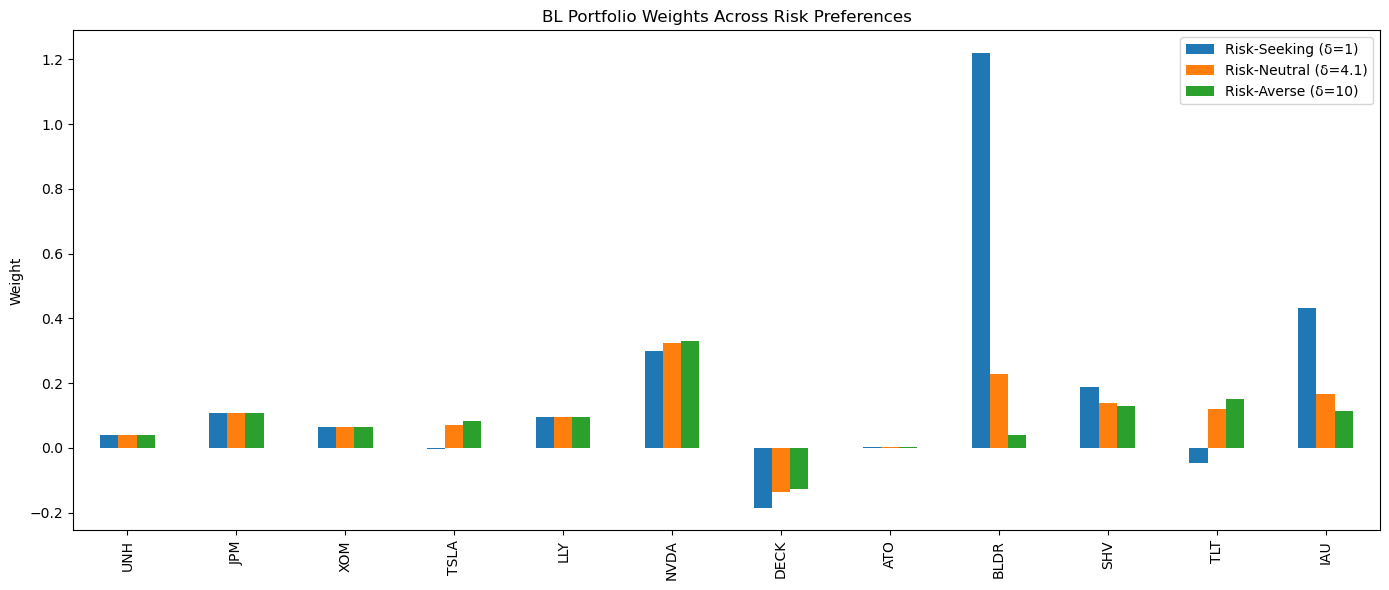

In [271]:

def compare_risk_levels(market_weights, cov_matrix, P, Q, tau=0.05):
    """
    Compare Black-Litterman portfolio weights across different risk aversion levels.
    Returns both weights DataFrame and a dictionary of daily return series.
    """
    risk_levels = {
        "Risk-Seeking (δ=1)": 1,
        "Risk-Neutral (δ=4.1)": 4.1,
        "Risk-Averse (δ=10)": 10
    }

    weight_df = pd.DataFrame(index=asset_names)
    portfolio_returns = {}

    for label, delta in risk_levels.items():
        model = BlackLittermanModel(
            market_weights=market_weights,
            cov_matrix=cov_matrix,
            P=P,
            Q=Q,
            tau=tau,
            risk_aversion=delta
        )
        weights = model.bl_weights().flatten()
        weight_df[label] = weights

        # Compute daily portfolio returns using filtered daily returns
        daily_returns = filtered_daily_ret.dot(weights)
        portfolio_returns[label] = daily_returns

    return weight_df, portfolio_returns

weights_comparison, return_comparison = compare_risk_levels(market_weights, cov_matrix, P, Q)
weights_comparison.plot(kind="bar", figsize=(14,6), title="BL Portfolio Weights Across Risk Preferences")
plt.ylabel("Weight")
plt.tight_layout()
plt.show()

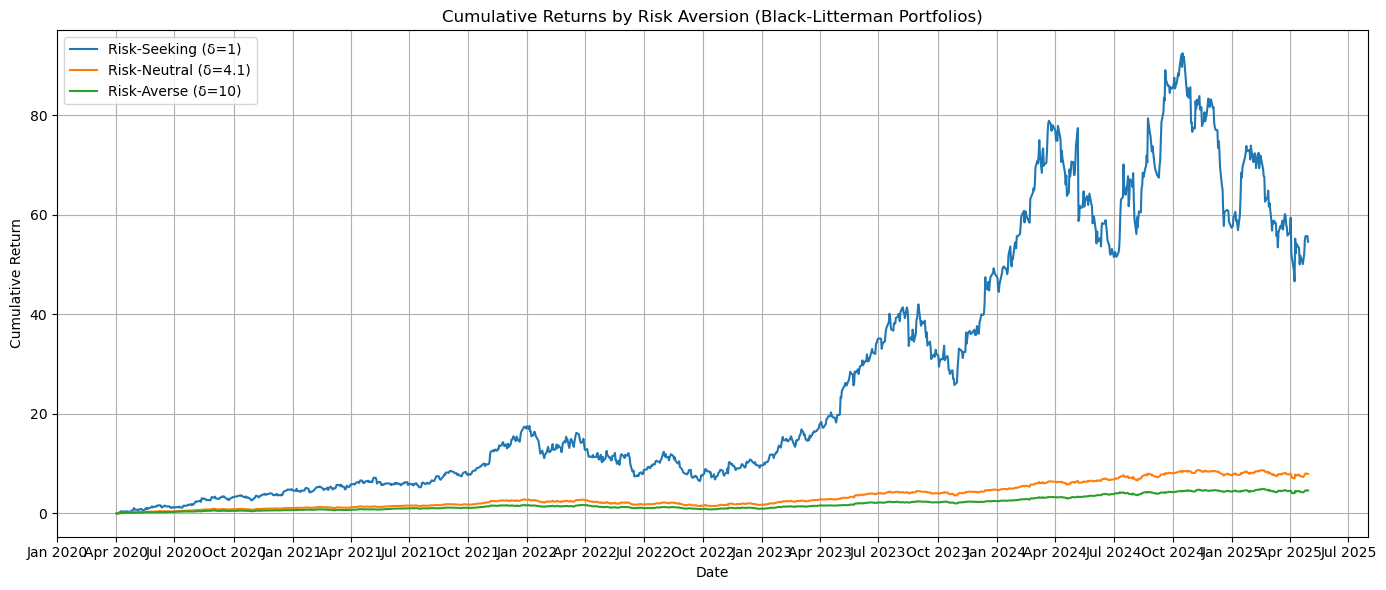

In [274]:
# Plot cumulative returns
plt.figure(figsize=(14, 6))
for label, returns in return_comparison.items():
    cum_returns = (1 + returns).cumprod() - 1
    cum_returns.index = pd.to_datetime(cum_returns.index)
    plt.plot(cum_returns.index, cum_returns, label=label)

plt.title("Cumulative Returns by Risk Aversion (Black-Litterman Portfolios)")
plt.ylabel("Cumulative Return")
plt.xlabel("Date")
plt.legend()
plt.grid(True)
# Set x-axis to show quarterly ticks (Jan, Apr, Jul, Oct)
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 4, 7, 10)))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

plt.tight_layout()
plt.show()